In [20]:
import numpy as np
import pandas as pd
import ransac
import scipy

# Ransac

In [12]:
signedMLS = np.array([-18.38,
13.56,
-10.67,
13.54,
15.73,
23.1,
16.67,
13.45,
-11.36,
9.239,
-19,
9.614])

HdiffBrainRatio = np.array([0.015285775,
-0.072462266,
0.033633871,
-0.037388472,
-0.03993227,
-0.066418432,
-0.053306924,
-0.036909235,
0.031145285,
-0.023499193,
0.016519748,
-0.014498427])

In [26]:
all_data = np.vstack((signedMLS, HdiffBrainRatio)).T

In [27]:
# n_samples = 500
# n_inputs = 1
# n_outputs = 1
# A_exact = 20*np.random.random((n_samples,n_inputs) )
# perfect_fit = 60*np.random.normal(size=(n_inputs,n_outputs) ) # the model
# B_exact = scipy.dot(A_exact,perfect_fit)
# assert B_exact.shape == (n_samples,n_outputs)

# # add a little gaussian noise (linear least squares alone should handle this well)
# A_noisy = A_exact + np.random.normal(size=A_exact.shape )
# B_noisy = B_exact + np.random.normal(size=B_exact.shape )

# if 1:
#     # add some outliers
#     n_outliers = 100
#     all_idxs = np.arange( A_noisy.shape[0] )
#     np.random.shuffle(all_idxs)
#     outlier_idxs = all_idxs[:n_outliers]
#     non_outlier_idxs = all_idxs[n_outliers:]
#     A_noisy[outlier_idxs] =  20*np.random.random((n_outliers,n_inputs) )
#     B_noisy[outlier_idxs] = 50*np.random.normal(size=(n_outliers,n_outputs) )

# # setup model

# all_data = np.hstack( (A_noisy,B_noisy) )

In [28]:
all_data

array([[ -1.83800000e+01,   1.52857750e-02],
       [  1.35600000e+01,  -7.24622660e-02],
       [ -1.06700000e+01,   3.36338710e-02],
       [  1.35400000e+01,  -3.73884720e-02],
       [  1.57300000e+01,  -3.99322700e-02],
       [  2.31000000e+01,  -6.64184320e-02],
       [  1.66700000e+01,  -5.33069240e-02],
       [  1.34500000e+01,  -3.69092350e-02],
       [ -1.13600000e+01,   3.11452850e-02],
       [  9.23900000e+00,  -2.34991930e-02],
       [ -1.90000000e+01,   1.65197480e-02],
       [  9.61400000e+00,  -1.44984270e-02]])

In [117]:
input_columns = range(n_inputs) # the first columns of the array
output_columns = [n_inputs+i for i in range(n_outputs)] # the last columns of the array
debug = False
model = ransac.LinearLeastSquaresModel(input_columns,output_columns,debug=debug)

linear_fit,resids,rank,s = scipy.linalg.lstsq(all_data[:,input_columns],
                                              all_data[:,output_columns])

# run RANSAC algorithm
ransac_fit, ransac_data = ransac.ransac(all_data,model,
                                 4, 1000, 1e-4, 4, # misc. parameters
                                 debug=debug,return_all=True)

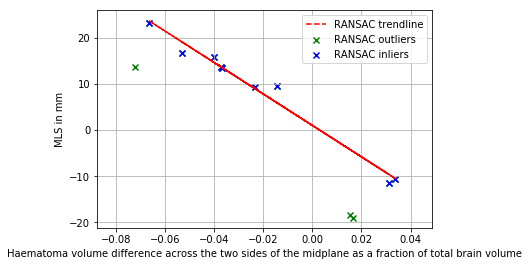

In [155]:
import matplotlib.pyplot as plt

plt.clf()

pylab.scatter(HdiffBrainRatio, signedMLS, marker='x', c='g', label='RANSAC outliers')
# z = np.polyfit(HdiffBrainRatio, signedMLS, 1)
# p = np.poly1d(z)
# pylab.plot(x,p(x),"g--", label='least squares from all data points')

y, x = np.vstack((signedMLS[ransac_data['inliers']], HdiffBrainRatio[ransac_data['inliers']]))
pylab.scatter(x, y, marker='x', c='b', label='RANSAC inliers')
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
pylab.plot(x,p(x),"r--", label='RANSAC trendline')

plt.xlabel('Haematoma volume difference across the two sides of the midplane as a fraction of total brain volume')
plt.ylabel('MLS in mm')

plt.grid()

plt.legend()
plt.show()

# Heatmaps

In [156]:
import os

In [167]:
# left H - right H

paths = ['/Volumes/SINEADUSB/Scans/ScanB/', 
        '/Volumes/SINEADUSB/Scans/ScanD/',
        '/Volumes/SINEADUSB/Scans/ScanE/',
        '/Volumes/SINEADUSB/Scans/ScanF/',
        '/Volumes/SINEADUSB/Scans/ScanG/',
        '/Volumes/SINEADUSB/Scans/ScanH/',
        '/Volumes/SINEADUSB/Scans/ScanI/',
        '/Volumes/SINEADUSB/Scans/ScanJ/',
        '/Volumes/SINEADUSB/Scans/ScanK/',
        '/Volumes/SINEADUSB/Scans/ScanL/',
        '/Volumes/SINEADUSB/Scans/ScanM/',
        '/Volumes/SINEADUSB/Scans/ScanN/',
        '/Volumes/SINEADUSB/Scans/ScanO/']
Hpaths = []

for i in range(len(paths)):
    Hpaths.append(os.path.join(paths[i], 'resultslefth.nii.gz'))
    Hpaths.append(os.path.join(paths[i], 'resultsrighth.nii.gz'))
    
Hpaths = np.reshape(np.array(Hpaths), [len(paths),2])

In [169]:
import nibabel as nib

In [182]:
H1 = nib.load(Hpaths[0][0]).get_data()
H2 = nib.load(Hpaths[0][1]).get_data()
Hdiff = H1 - H2

In [226]:
def area_difference(maskLHS, maskRHS):
    diff = np.zeros((maskLHS.shape[2], maskRHS.shape[1]))
    for k in range(maskLHS.shape[2]):
        for j in range(maskLHS.shape[1]): 
            # x y z defined according to miplane vertical (not horizontal as is the default in imshow)
            areaLHS=np.sum(maskLHS[:,j,k])
            areaRHS=np.sum(maskRHS[:,j,k])
            diff[k,j] = (areaRHS-areaLHS)*0.0001
    return diff

In [227]:
h_diff = area_difference(H1, H2)
# brain_diff = area_difference(mask_lb, mask_rb)

In [196]:
pixelspacing = np.array([0.453125, 0.453125, 1.5035966386554538])

In [228]:
h_diff

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [255]:
lst = np.vstack((h_diff.nonzero())).T

In [256]:
vals = []
for i in range(len(lst)):
    vals.append(h_diff[lst[i][0], lst[i][1]])

In [270]:
inds = lst.T
tuples = np.vstack((inds, vals))


In [271]:
tuples

array([[  3.20000000e+01,   3.20000000e+01,   3.20000000e+01, ...,
          8.40000000e+01,   8.40000000e+01,   8.40000000e+01],
       [  3.82000000e+02,   3.83000000e+02,   3.84000000e+02, ...,
          2.98000000e+02,   2.99000000e+02,   3.00000000e+02],
       [ -2.00000000e-04,  -2.00000000e-04,  -2.00000000e-04, ...,
         -1.00000000e-04,  -1.00000000e-04,  -1.00000000e-04]])

<IPython.core.display.Javascript object>


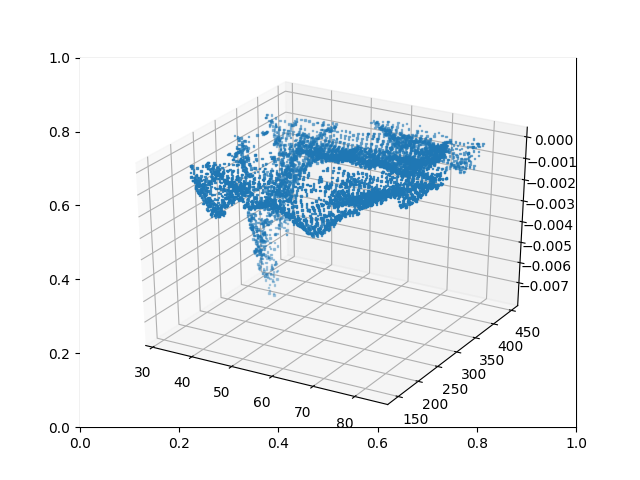

In [289]:
%matplotlib nbagg
fig, ax = plt.subplots()
from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tuples[0], tuples[1], tuples[2], marker = ",", s=1)
plt.show()
plt.ion()

<IPython.core.display.Javascript object>


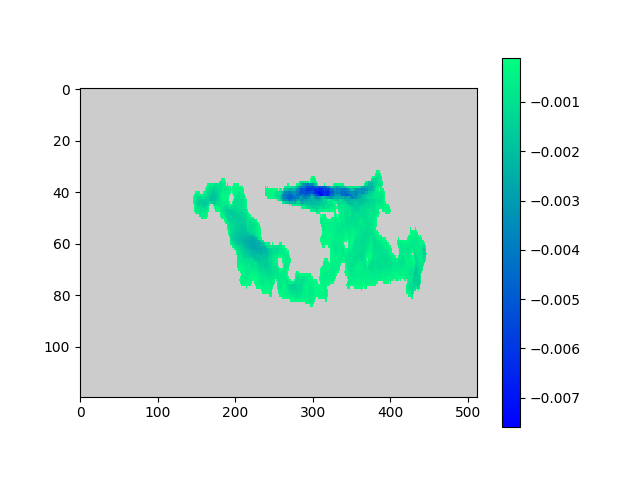

In [274]:
%matplotlib nbagg
fig, ax = plt.subplots()
h_diff[h_diff==0]=np.nan
palette = plt.cm.winter
palette.set_bad(alpha=0.2)
heatmap = ax.imshow(h_diff, cmap=palette)
# heatmap = ax.pcolor(brain_diff==0, cmap=plt.cm.winter)
# plt.xlim(0, 249)
# plt.ylim (176,0)
ax.set_aspect(pixelspacing[2]/pixelspacing[1])
plt.colorbar(heatmap)
plt.show()
plt.ion()

In [ ]:
%matplotlib nbagg
fig, ax = plt.subplots()
h_diff[h_diff==0]=np.nan
palette = plt.cm.winter
palette.set_bad(alpha=0.2)
heatmap = ax.imshow(h_diff, cmap=palette)
# heatmap = ax.pcolor(brain_diff==0, cmap=plt.cm.winter)
# plt.xlim(0, 249)
# plt.ylim (176,0)
ax.set_aspect(pixelspacing[2]/pixelspacing[1])
plt.colorbar(heatmap)
plt.show()
plt.ion()